In [ ]:
# Install the required libraries
!pip install prophet

In [1]:
# Dependencies
# NOTE: We might not use all of these. I just improrted everything I can think of for now. We'll delete the ones we don't need later
import requests
import time
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import json
import path

ModuleNotFoundError: No module named 'path'

In [ ]:
#Read data into the notebook
linkedin_postings_df = pd.read_csv('./data_sets/postings.csv').dropna()
machine_learning_jobs_df = pd.read_json('./data_sets/job_data.json', lines=True)

# Normalize, clean, massage, and combine data for ease of processing

# Cast all job skills to lower case strings to standardize string matching later
linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills'].apply(lambda item: item.lower().split(', '))

***Introduction*** 
The goal of this exploratory data analysis is to characterize and investigate the growth of machine learning as a job skill. We are interested in looking at this topic along a number angles. TBC....

QUESTION Geography 

In [ ]:
# Insert Question 1 analysis and visualizations here. Insert new cells if necessary 

Q1 Summary \[INSERT SUMMARY HERE] ... write a little about what the findings above seem to indicate about question 1

Question 2 Relative proportions ML to not-ML

In [ ]:
# Insert question 2 analysis etc here. Insert new cells if necessary

Q2 Summary \[INSERT SUMMARY HERE]

Question Job Skills

Question Seniority/Job level

In [ ]:
# etc 

Question 5 Industry demand 

In [ ]:
QUESTION: AI MODELS

In [2]:
# Read data into notebook
ai_index_df = pd.read_csv('./data_sets/ai_job_index.csv')

# Visualzie and explore the dataframe
ai_index_df

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain
0,Communications Manager,98%,365,2546,0.143362,Communication & PR
1,Data Collector,95%,299,2148,0.139199,Data & IT
2,Data Entry,95%,325,2278,0.142669,Administrative & Clerical
3,Mail Clerk,95%,193,1366,0.141288,Leadership & Strategy
4,Compliance Officer,92%,194,1369,0.141709,Medical & Healthcare
...,...,...,...,...,...,...
4701,Singer,5%,686,2798,0.245175,Data & IT
4702,Airport,5%,556,2206,0.252040,Administrative & Clerical
4703,Director,5%,1316,4695,0.280298,Leadership & Strategy
4704,Nurse,5%,710,2594,0.273709,Medical & Healthcare


In [3]:
# Analyze the "Domain" column for unique values.
ai_index_df['Domain'].unique()

array(['Communication & PR', 'Data & IT', 'Administrative & Clerical',
       'Leadership & Strategy', 'Medical & Healthcare',
       'Supply Chain & Logistics', 'Law Enforcement', 'Construction',
       'Sales & Marketing', 'Hospitality'], dtype=object)

In [4]:
#Rename "Domain" column to "Sectors" to match notebook analysis
ai_index_df = ai_index_df.rename(columns={'Domain':'Sector'})
ai_index_df

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Sector
0,Communications Manager,98%,365,2546,0.143362,Communication & PR
1,Data Collector,95%,299,2148,0.139199,Data & IT
2,Data Entry,95%,325,2278,0.142669,Administrative & Clerical
3,Mail Clerk,95%,193,1366,0.141288,Leadership & Strategy
4,Compliance Officer,92%,194,1369,0.141709,Medical & Healthcare
...,...,...,...,...,...,...
4701,Singer,5%,686,2798,0.245175,Data & IT
4702,Airport,5%,556,2206,0.252040,Administrative & Clerical
4703,Director,5%,1316,4695,0.280298,Leadership & Strategy
4704,Nurse,5%,710,2594,0.273709,Medical & Healthcare


In [5]:
# Clean the data by removing leading/trailing spaces by removing special characters
ai_index_df['Sector'] = ai_index_df['Sector'].replace('[^\w\s]', '', regex=True)
ai_index_df

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Sector
0,Communications Manager,98%,365,2546,0.143362,Communication PR
1,Data Collector,95%,299,2148,0.139199,Data IT
2,Data Entry,95%,325,2278,0.142669,Administrative Clerical
3,Mail Clerk,95%,193,1366,0.141288,Leadership Strategy
4,Compliance Officer,92%,194,1369,0.141709,Medical Healthcare
...,...,...,...,...,...,...
4701,Singer,5%,686,2798,0.245175,Data IT
4702,Airport,5%,556,2206,0.252040,Administrative Clerical
4703,Director,5%,1316,4695,0.280298,Leadership Strategy
4704,Nurse,5%,710,2594,0.273709,Medical Healthcare


In [6]:
# Define keywords to group Sectors in preparation for further analysis and aggregation.
sector_grouping = {'Communication  PR':'Media', 'Data  IT':'Tech', 'Administrative  Clerical':'Clerical',
                   'Leadership  Strategy':'Consulting', 'Medical  Healthcare':'Healthcare',
                   'Supply Chain  Logistics':'Manufacturing', 'Law Enforcement':'Law Enforcement', 
                   'Construction':'Construction','Sales  Marketing':'Marketing', 'Hospitality':'Hospitality'}

ai_index_df['Sector'] = ai_index_df['Sector'].replace(sector_grouping)
ai_index_df

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Sector
0,Communications Manager,98%,365,2546,0.143362,Media
1,Data Collector,95%,299,2148,0.139199,Tech
2,Data Entry,95%,325,2278,0.142669,Clerical
3,Mail Clerk,95%,193,1366,0.141288,Consulting
4,Compliance Officer,92%,194,1369,0.141709,Healthcare
...,...,...,...,...,...,...
4701,Singer,5%,686,2798,0.245175,Tech
4702,Airport,5%,556,2206,0.252040,Clerical
4703,Director,5%,1316,4695,0.280298,Consulting
4704,Nurse,5%,710,2594,0.273709,Healthcare


In [7]:
# Rename columns for further analysis and clarity
ai_index_df = ai_index_df.rename(columns={'Tasks':'Human Tasks'})
ai_index_df

,Job titiles,AI Impact,Human Tasks,AI models,AI_Workload_Ratio,Sector
0,Communications Manager,98%,365,2546,0.143362,Media
1,Data Collector,95%,299,2148,0.139199,Tech
2,Data Entry,95%,325,2278,0.142669,Clerical
3,Mail Clerk,95%,193,1366,0.141288,Consulting
4,Compliance Officer,92%,194,1369,0.141709,Healthcare
...,...,...,...,...,...,...
4701,Singer,5%,686,2798,0.245175,Tech
4702,Airport,5%,556,2206,0.252040,Clerical
4703,Director,5%,1316,4695,0.280298,Consulting
4704,Nurse,5%,710,2594,0.273709,Healthcare


In [8]:
# Drop colummns that don't pertain to further aggregation and visualization
ai_index_df = ai_index_df.drop(columns=['Job titiles','AI Impact','AI_Workload_Ratio'])
ai_index_df

,Human Tasks,AI models,Sector
0,365,2546,Media
1,299,2148,Tech
2,325,2278,Clerical
3,193,1366,Consulting
4,194,1369,Healthcare
...,...,...,...
4701,686,2798,Tech
4702,556,2206,Clerical
4703,1316,4695,Consulting
4704,710,2594,Healthcare


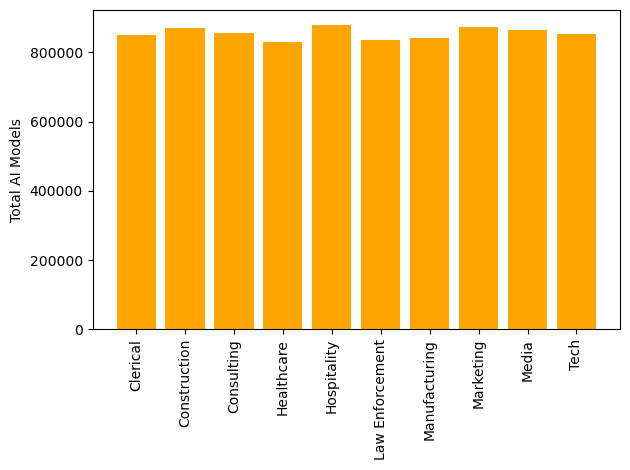

In [14]:
# Groupby "Sector" and use the sum() aggregation function on the "AI Models" column to calculate the total number of AI models per Sector
# Visualize data for further analysis.
models_by_sectors = ai_index_df.groupby('Sector')['AI models'].sum()
models_by_sectors_df = models_by_sectors.reset_index()
models_by_sectors_df = models_by_sectors_df.rename(columns={'AI models':'AI Models by Sector'})
plt.bar(models_by_sectors_df['Sector'], models_by_sectors_df['AI Models by Sector'], color='orange')
plt.xticks(rotation=90)
plt.ylabel('Total AI Models')
plt.tight_layout()
plt.savefig('AI_Models', dpi=300)
plt.show()

This bar graph provides a visual representation of the prevalence of AI Models in the workforce, with at least 800,000 AI models being used in every "Sector" of the dataset.

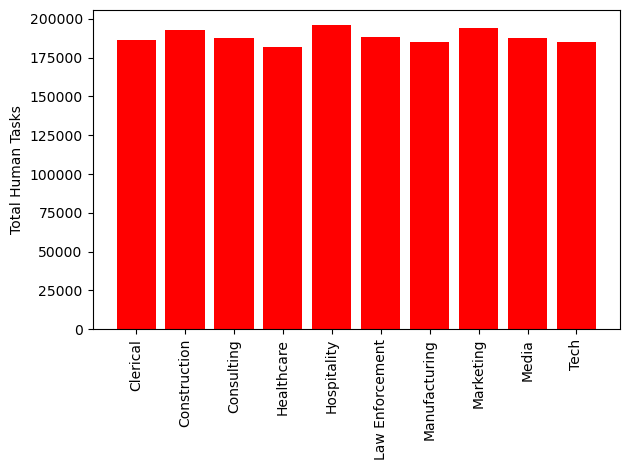

In [15]:
# Groupby "Sector" and use the sum() aggregation function on the "Human Tasks" column to calculate the total amount of Human Tasks per Sector
# Visualize data for further analysis.
tasks_by_sectors = ai_index_df.groupby('Sector')['Human Tasks'].sum()
tasks_by_sectors_df = tasks_by_sectors.reset_index()
plt.bar(tasks_by_sectors_df['Sector'], tasks_by_sectors_df['Human Tasks'], color='red')
plt.xticks(rotation=90)
plt.ylabel('Total Human Tasks')
plt.tight_layout()
plt.savefig('Human_Tasks.png', dpi=300)
plt.show()

Comparatively, this bar graph provides a visual representation of the "Total Human Tasks" by "Sector" replaceable by AI Models. Calculating the proportions of "Human Tasks" to "AI Models" will provide more insight.

In [16]:
# Merge the AI Models and Human Tasks dataframe and calculate the proportion of Human Tasks to AI Models
ai_workload = pd.merge(tasks_by_sectors_df, models_by_sectors_df, on='Sector', how='outer')
ai_workload['AI Proportion'] = ai_workload['Human Tasks']/ai_workload['AI Models by Sector']
ai_workload

,Sector,Human Tasks,AI Models by Sector,AI Proportion
0,Clerical,186362,851666,0.218821
1,Construction,193045,869222,0.222089
2,Consulting,187825,856027,0.219415
3,Healthcare,182109,829359,0.219578
4,Hospitality,195841,878642,0.222891
5,Law Enforcement,188565,835861,0.225594
6,Manufacturing,185271,841216,0.220242
7,Marketing,193988,872181,0.222417
8,Media,187881,865207,0.217152
9,Tech,184845,854612,0.216291


In [17]:
# Use pandas statistical analysis to determine the mean AI workload based on the "Proportion" column.
ai_workload['AI Proportion'].describe()

count    10.000000
mean      0.220449
std       0.002822
min       0.216291
25%       0.218969
50%       0.219910
75%       0.222335
max       0.225594
Name: AI Proportion, dtype: float64

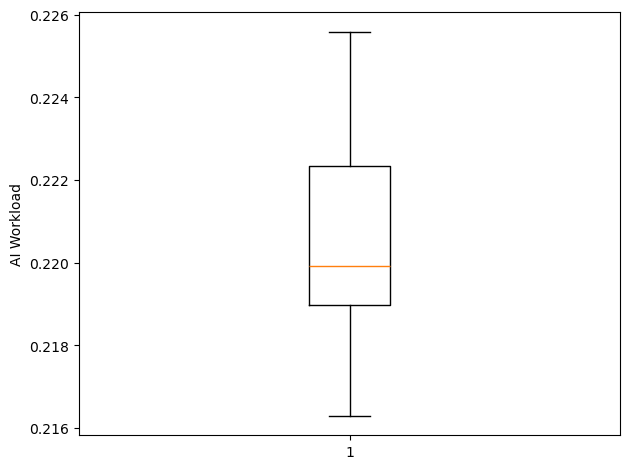

In [19]:
# Use statistical visualization to confirm findings
plt.boxplot(ai_workload['AI Proportion'])
plt.ylabel('AI Workload')
plt.tight_layout()
plt.savefig('AI_Workload.png', dpi=300)
plt.show()

Based on the total proportions of "Human Tasks" to "AI Models", the statistical analysis revealed an average AI model workload of 22%, meaning for every individual human task, there are 4-5 AI models being trained as replacements. This shift to a more technological landscape raises many questions while providing insight on future employment trends.